# This tutorial shows the process of using the SUREMO command to call metacells for multi-omics datasets.

In [1]:
import tempfile
import os

import subprocess
import scanpy as sc 
import datatable as dt 
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import umap 

from SURE import SUREMO

import torch 
torch.set_float32_matmul_precision("high")


codebook_size=500 # number of metacells

/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2024-11-08 14:23:19.695775: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-08 14:23:19.703095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 14:23:19.715065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 14:23:19.718676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 14:23:19.727927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

## Download and load the dataset

The dataset used is accessible at the NCBI GEO site with the accession [GSE194122](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122). It is produced by using 10x multiome.

In [2]:
adata = sc.read_h5ad('/media/oem/UB20_DATA/Workspace/Tutorial/tutorial_2/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')

# process RNA modality
genes=adata.var_names[adata.var['feature_types']=='GEX']
adata_gex=adata[:,genes].copy()
adata_gex.X = adata_gex.layers['counts'].copy()

sc.pp.normalize_total(adata_gex, target_sum=1e4)
sc.pp.log1p(adata_gex)
sc.pp.highly_variable_genes(adata_gex, n_top_genes=4000, subset=True)



In [3]:
# process ATAC modality
genes=adata.var_names[adata.var['feature_types']=='ATAC']
adata_atac=adata[:,genes].copy()
adata_atac.X = adata_atac.layers['counts'].copy()

sc.pp.normalize_total(adata_atac, target_sum=1e4)
sc.pp.log1p(adata_atac)
sc.pp.highly_variable_genes(adata_atac, n_top_genes=10000, subset=True)

## Use SURE to call metacells within this dataset

### Prepare the input files and run the SUREMO command

In [4]:
with tempfile.TemporaryDirectory() as temp_dir:
    # write RNA counts to a local file
    xs1 = adata_gex.layers['counts'].toarray()
    rna_counts_file = os.path.join(temp_dir, 'temp_rna_counts.txt.gz')
    dt.Frame(pd.DataFrame(xs1, columns=adata_gex.var_names, dtype=np.float64)).to_csv(rna_counts_file)

    # write ATAC counts to a local file
    xs2 = adata_atac.layers['counts'].toarray()
    atac_counts_file = os.path.join(temp_dir, 'temp_atac_counts.txt.gz')
    dt.Frame(pd.DataFrame(xs2, columns=adata_atac.var_names, dtype=np.float64)).to_csv(atac_counts_file)

    # write undesired factors to a local file
    enc = OneHotEncoder(sparse_output=False).fit(adata_gex.obs['batch'].to_numpy().reshape(-1,1))
    us = enc.transform(adata_gex.obs['batch'].to_numpy().reshape(-1,1))
    uwv_file = os.path.join(temp_dir, 'temp_uwv.txt.gz')
    pd.DataFrame(us, columns=enc.categories_).to_csv(uwv_file, index=False)

    # call SUREMO
    model_file = os.path.join(temp_dir, f'temp_suremo_{codebook_size}.txt.gz')
    cmd = f'CUDA_VISIBLE_DEVICES=0  SUREMO --omic1-file "{rna_counts_file}" \
    --omic2-file "{atac_counts_file}" \
    --undesired-factor-file "{uwv_file}" \
    --jit \
    --seed 0 \
    --cuda \
    -lr 0.0001 \
    -n 200 \
    -bs 512 \
    -cs {codebook_size} \
    -dirichlet \
    -likeli1 negbinomial \
    -likeli2 negbinomial \
    -zi1 exact \
    -zi2 exact \
    --save-model "{model_file}"'

    subprocess.call(cmd, shell=True)

    # load the model
    model = SUREMO.load_model(model_file)

100%|██████████| 68/68 [00:00<00:00, 164.30batch/s]


Model saved to /tmp/tmp4awvcnfp/temp_suremo_500.txt.gz
Model loaded from /tmp/tmp4awvcnfp/temp_suremo_500.txt.gz


### Get the latent representations of cells

In [5]:
zs = model.get_cell_coordinates(xs1, xs2)

umap_model = umap.UMAP().fit(zs)
adata.obsm['X_umap'] = umap_model.transform(zs)

100%|██████████| 68/68 [00:00<00:00, 139.17batch/s]


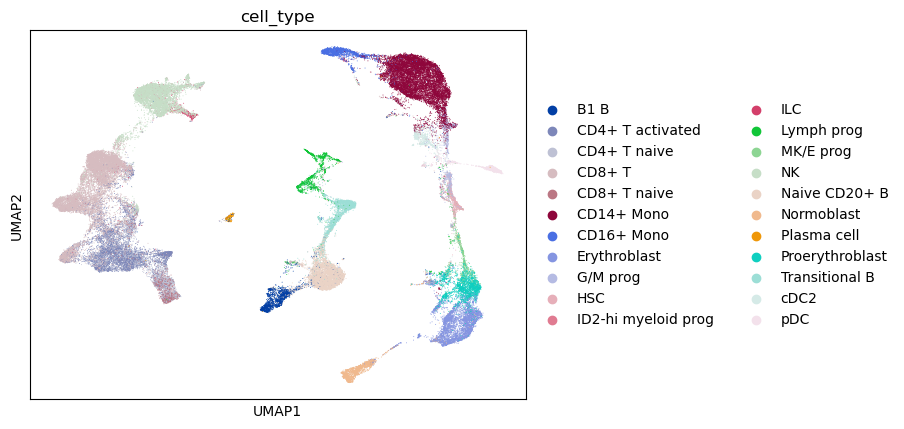

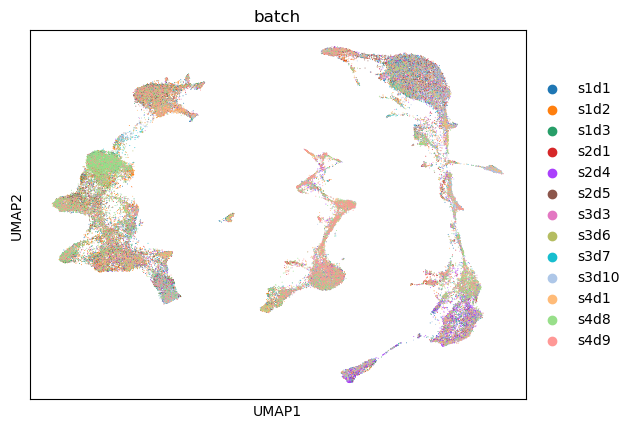

In [6]:
sc.pl.umap(adata, color='cell_type')
sc.pl.umap(adata, color='batch')

### Get metacells

In [7]:
zs_metacells = model.get_metacell_coordinates()
umap_metacells = umap_model.transform(zs_metacells)

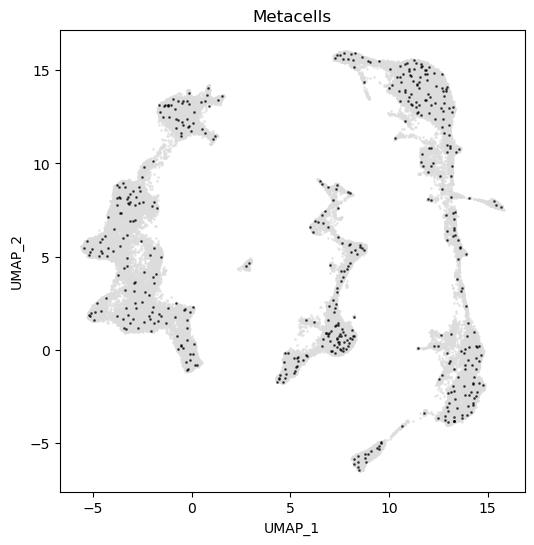

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))  # Set the figure size
plt.scatter(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1], s=1, c='gainsboro', alpha=0.6)
plt.scatter(umap_metacells[:,0], umap_metacells[:,1], s=1, c='black', alpha=0.6)


# Add labels and title
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.title('Metacells')

# Show the plot
plt.show()